<a href="https://colab.research.google.com/github/jefftrojan/chatbot-app/blob/main/cropbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Import BERT-base pretrained model
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
df = pd.read_csv("crop_diseases.csv")
df.head()

,Questions,Answers,Patterns,Tags
0,What is crop rotation?,Crop rotation is the practice of growing diffe...,Can you explain the concept of crop rotation?,Crop Rotation
1,What is the primary benefit of crop rotation?,The primary benefit of crop rotation is the im...,Why is crop rotation beneficial?,Soil Health
2,What is a cover crop?,A cover crop is a plant grown primarily to pro...,What is the purpose of a cover crop?,Cover Crops
3,What are common cover crops?,"Common cover crops include clover, rye, and ve...",Can you name some examples of cover crops?,Crop Examples
4,What is monoculture?,Monoculture is the agricultural practice of gr...,What does monoculture mean?,Monoculture


In [9]:

# Creating intents dictionary
dict_ = {"intents": []}

for ind in df.index:
    questions = df['Questions'][ind].lower().replace('?', '.').split('.')
    patterns = [q.strip() for q in questions if q.strip()]
    patterns.append(df['Patterns'][ind].lower().strip())
    responses = df['Answers'][ind]
    tag = df['Tags'][ind]

    dict1 = {'tags': [tag], 'patterns': patterns, 'responses': [responses]}
    dict_['intents'].append(dict1)

print(dict_["intents"][:2])

with open("crops.json", "w") as f:
    json.dump(dict_, f)

[{'tags': ['Crop Rotation'], 'patterns': ['what is crop rotation', 'can you explain the concept of crop rotation?'], 'responses': ['Crop rotation is the practice of growing different types of crops in the same area in sequential seasons to improve soil health and reduce pests.']}, {'tags': ['Soil Health'], 'patterns': ['what is the primary benefit of crop rotation', 'why is crop rotation beneficial?'], 'responses': ['The primary benefit of crop rotation is the improvement of soil fertility and the reduction of soilborne diseases and pests.']}]


In [10]:
words=[]
classes=[]
documents=[]
ignore_letters=['?','!','.',',']
lemmatizer = WordNetLemmatizer()


def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

In [11]:


# Prepare training data
training = []
output_empty = [0] * len(classes)
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

In [18]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

model=Sequential()
model.add(Dense(128,input_shape=(len(train_x[1]),),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]),activation='softmax'))


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
# sgd=SGD(learning_rate=0.0001,decay=1e-6,momentum=0.9,nesterov=True)


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','Precision','Recall'])
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=METRICS)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 38)                  │           2,470 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,158 (426.40 KB)

 Trainable params: 109,158 (426.40 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
hist = model.fit(np.array(train_x),np.array(train_y),epochs=50,batch_size=12,verbose=1)
model.save('chatbotmodel.h5', hist)
print('Training Done')

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0053 - loss: 3.6796    
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0752 - loss: 3.5151 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0694 - loss: 3.4369  
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1433 - loss: 3.3178      
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2543 - loss: 3.1321 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2077 - loss: 2.9600  
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2101 - loss: 2.8880  
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 

Training Done


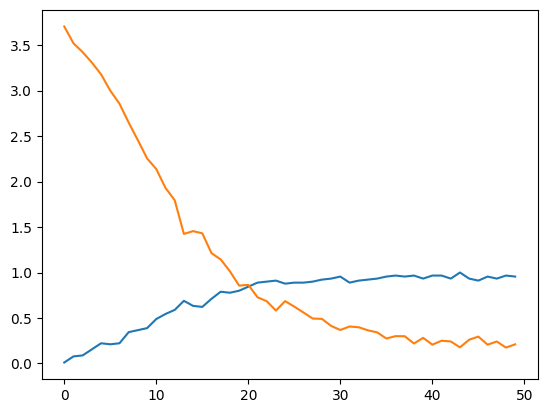

In [16]:
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['loss'],label='loss')
plt.show()


In [15]:
# Load the model for prediction
model = load_model('chatbotmodel.h5')

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "Sorry, I don't understand."

print("ChatBot is Active")

while True:
    message = input("")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    ints = predict_class(message)
    if ints:
        res = get_response(ints, dict_)
        print(f"Bot: {res}")
    else:
        print("Bot: Sorry, I don't understand.")

ChatBot is Active
Hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Bot: Sorry, I don't understand.
What is crop cover
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Bot: Crop yield refers to the amount of crop produced per unit area of land.
crop cover
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Bot: Common cover crops include clover, rye, and vetch.


KeyboardInterrupt: Interrupted by user